In [1]:
# Venga, vamos con selección de características para un problema de clasificación (intención de voto) a partir de datos de
 #encuesta del Sociómetro del pasado mes de marzo, y sirviéndonos de un modelo de random forest para dicha selección.

# Importamos librerías y cargamos el dataframe desde la url de descarga del "Sociómtero Vasco 83, 
 #Elecciones Autonómicas: previsión de voto".

import numpy as np
import pandas as pd

df = pd.read_csv("https://www.euskadi.eus/contenidos/ds_informes_estudios/od_24sv83/opendata/24sv83.csv", sep = ";")

# Realizamos un análisis exploratorio básico y comprobamos, tal y como era de esperar, que no hay NA's. Los profesionales 
 #del Sociómetro ya se han encargado de limpiar la BBDD por nosotros. # Además, el análisis exploratorio muestra cómo 79 
 #de 80 variables son de tipo numérico.

df.head()
df.describe()
df.isna().sum().sum()
df.dtypes.value_counts()

# Además, hemos identificado 3 variables que no aportarán nada al modelo: 'elkar', 'inkes' y 'wt' que son número 
 #de entrevista, número de encuestador y una variable interna de Sociómetro, respectivamente. Las eliminamos.

vars_to_drop = ['elkar', 'inkes', 'wt']
df.drop(vars_to_drop, axis = 1, inplace = True)

# Nuestra variable objetivo (intención de voto) sería la 'P21'. Primero etiquetamos sus categorías de respuesta 
 #(originalmente son números asociados a categorías de respuesta, en este caso opciones de voto), apoyandonos en un dict.
 # Despues, visualizamos su distribución.

p21_dict = {1:'PNV/EAJ', 2:'EH BILDU', 3:'PSE-EE', 4:'PODEMOS', 5:'SUMAR', 6:'PP', 7:'VOX', 8:'OTRO',
           9: 'NO VOTARÁ', 10:'VOTO BLANCO', 11:'VOTO NULO', 12:'NO SABE', 13:'NO CONTESTA', 14:'RESTO'}

df['P21'] = df['P21'].replace(p21_dict)

df['P21'].value_counts()

NO SABE        809
EH BILDU       571
PNV/EAJ        550
NO CONTESTA    411
RESTO          359
PSE-EE         152
PP              54
VOTO BLANCO     29
PODEMOS         26
SUMAR           26
VOX             15
VOTO NULO       13
OTRO            13
NO VOTARÁ        2
Name: P21, dtype: int64

In [2]:
# Vale, vamos a eliminar todas las categorías de respuesta que no sean una opción de voto concreta ('RESTO' hace referencia
 #a casos en que no hay respuesta)
    
cat_to_drop = ['NO SABE', 'NO CONTESTA', 'RESTO', 'NO VOTARÁ']
df = df[~df['P21'].isin(cat_to_drop)]

# Puedes hacer un df['P21'].value_counts() para comprobar que todo esta OK

# Bueno, pues ahora viene el curre tedioso (por manual, hay que ir mirando el cuestionario) de etiquetar todas las variables.
 #Originalmente tienen el código asociado a la pregunta, pero para el visualizado de características preferiremos algo más 
 #intuitivo.

original_colnames = list(df.columns)
new_colnames = ['Territorio', 'Fijo/Móvil', 'Idioma', 'Municipio', 'Sexo', 'Edad', 'Sit_Laboral', 'Salud', 'Seguridad', 
            'Sit_Política_Euskadi', 'Sit_Política_España', 'Sit_Econ_Euskadi', 'Sit_Econ_España', 'Evol_Econ_Eusk',
            'Evol_Econ_Esp', 'Probl_Económicos', 'Sit_Econ_Act', 'Sit_Econ_Niñ', 'Sit_Econ_Hij', 'Sit_Laboral',
            'Trab_Estabilidad', 'Trab_Salario', 'Trab_Interesante', 'Trab_Útil', 'Trab_Horario', 'Satisf_Estabilidad',
            'Satisf_Salario', 'Satisf_Interesante', 'Satisf_Útil', 'Satisf_Horario', 'Sit_Trabajo_Deseada',
            'Interés_Política', 'Suele_Votar', 'Interés_Próximas_Elecciones', 'Probabilidad_Votar', 'Intención_Voto',
            'Seguridad_Int_Voto', 'Recuerdo_Voto', 'Partidos_Nunca_votaría1', 'Partidos_Nunca_votaría2',
            'Partidos_Nunca_votaría3', 'Partidos_Podría_Votar1', 'Partidos_Podría_Votar2', 'Partidos_Podría_Votar3',
            'Simpatía_PNV', 'Simpatía_Bildu', 'Simpatía_PSE', 'Simpatía_Podemos', 'Simpatía_Sumar', 'Simpatía_PP',
            'Simpatía_VOX', 'Conoce_PNV', 'Conoce_Bildu', 'Conoce_PSE', 'Conoce_Podemos', 'Conoce_Sumar', 'Conoce_PP',
            'Conoce_VOX', 'Valora_PNV', 'Valora_Bildu', 'Valora_PSE', 'Valora_Podemos', 'Valora_Sumar', 'Valora_PP',
            'Valora_VOX', 'Escala_Ideológica', 'Escala_Nacionalista', 'Sentimiento_Nacional', 'Independencia', 'Euskera',
            'Estudios', 'Clase_Social', 'Provincia_Nacimiento', 'Nacionalidad_Esp', 'Género', 'Tlf-Fijo', 'Tlf_Móvil']

tuple_colnames = zip(original_colnames, new_colnames)
dict_colnames = dict(tuple_colnames)

df.rename(columns=dict_colnames, inplace=True)

# Puedes hacer un df.columns para comprobar que el cambio se ha realizado correctamente.
# Y nada, esto ya estaría listo. Podemos entrenar un modelo de random forest para seleccionar características.

# Café para muy cafeteros esto que sigue.
 #Los datos en realidad están un poco regu. Como el objeto de este script es mostrar cómo sacar las importances, pues
 #vaya. Pero si quisiéramos ser rigurosos y que el modelo predijese bien, tendríamos que revisar las variables ya que
 #muchas de ellas pese a ser numéricas, su número referencia una categoría de respuesta no ordinal (ergo, son categóricas).

In [3]:
# Hacemos los imports necesarios para ejecutar este bloque.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Cogemos el df completo, no vamos a hacer test pero sí tenemos que apartar la variable objetivo para el fit. Ah, y
 #guardarnos los nombres de las variables (features) para visualizar después (importances).

features = df.columns.drop(['Intención_Voto'])
X = df[features].values
y = df['Intención_Voto'].values

# Ahora vamos con lo dicho, instanciar y entrenar un modelo de random forest para visualizar importancia de características.
 #Y por el mismo precio, le metemos al modelo un grid, para optimizar parámetros.
    
maxDepth = range(1,15)
n_estimators = [200, 500, 1000]
tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estimators}

grid = GridSearchCV(RandomForestClassifier(random_state=17, max_features='sqrt'),  scoring='accuracy', param_grid=tuned_parameters,cv=5) 
grid.fit(X, y)

# Y ya puestos, solo por curiosear, vemos los mejores parámetros y las prestaciones nos ha dado el modelo.

print("best parameters: {}".format(grid.best_params_))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))

best parameters: {'max_depth': 12, 'n_estimators': 200}
best mean cross-validation score: 0.897


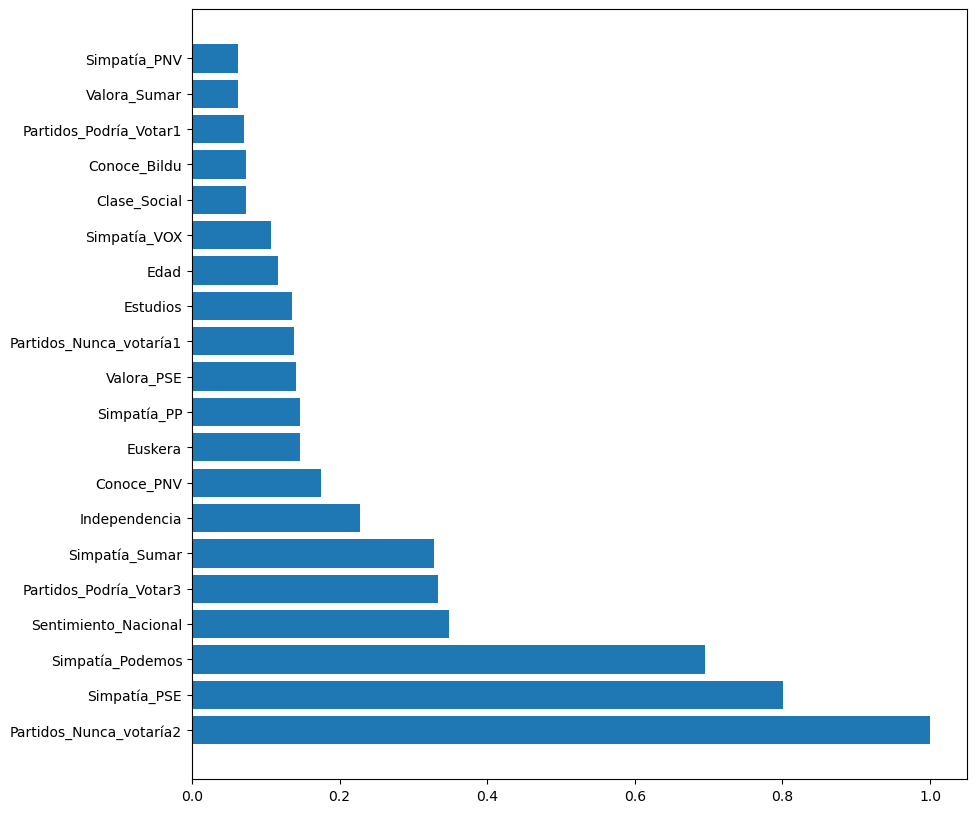

In [4]:
# Importamos librerías para visualizar

import matplotlib.pyplot as plt

# Los mejores parámetros son 12 de profundidad y 200 estimadores.
 #Además obtenemos un accuracy del 89,7%, que ni tan mal para el escasísimo preprocesado.

# Y ahora, finalmente, vamos con la visualización de las importances. Vamos a graficarlo, veremos qué variables son las que
 #tienen más peso en el modelo a la hora de predecir el voto. Nos apoyamos para ello en la variable 'features', creada 
 #anteriormente. Visualizaremos las 20 variables con mayor peso.

# Ah, e instanciamos y entrenamos el modelo de random forest con los mejores parámetros del grid.

rf = RandomForestClassifier(max_depth=12,n_estimators=200,max_features='sqrt').fit(X, y)
   
importances = rf.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]
indices = indices[:20]

plt.figure(figsize=(10,10))
plt.barh(range(len(indices)),importances[indices])
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

In [5]:
# Bueno, pues ya está, tenemos en pantalla las 20 variables que más peso tienen en el modelo a la hora de predecir el voto.
 #Y tienen todo el sentido. Las que más peso tienen son los partidos por los que nunca votaría ("Partidos_Nunca_Votaría2"),
 #la simpatía por algunos de ellos ("Simpatía_PSE", "Simpatía_Podemos") aquéllos a los que estaría dispuesto a votar 
 #("Partidos_Podría_Votar3"), el sentimiento nacional ("Sentimiento_Nacional"), el posicionamiento respecto a la 
 #independencia ("Independencia")...etc, creo que se entiende. Y eso, que parece muy coherente.

# ¿Estas son las variables qué más peso tienen para las personas a la hora de decidir el voto? Sí pero no. Son las 
 #variables que más peso tienen para nuestro modelo. Quizá haya variables que a la hora de decidir el voto pesen mucho
 #individualmente, pero que en conjunto e integradas en nuestro modelo se diluyen. Conclusión, lo dicho, son las variables
 #con más peso para nuestro modelo a la hora de predecir el voto y pueden servir para selección de características en caso 
 #de que queramos aligerar la carga computacional del modelo o una mayor capacidad de generalización.